In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#Regressions modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
%matplotlib inline

In [48]:
data = pd.read_csv("train.csv")
valid = pd.read_csv("test.csv")
test = valid.copy()


X = data.drop(columns = ["Survived"])
y = data["Survived"]

titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rey']
def clean(df):
    df['Title'] = df.Name.str.split(",")
    list = [row[1].split() for row in df.Title]
    list2 = [row[0].replace('.', '') for row in list]
    list3 = [x if x in titles else "blah" for x in list2]
    df['Title'] = list3
    df.drop(columns=['Name', 'PassengerId', 'Ticket', 'Cabin'], inplace=True)
    return df
clean(X)
clean(test)

X['Age'] = X['Age'].fillna(X.Age.median())
test['Age'] = test.groupby("Title")['Age'].transform('median')
test['Fare'] = test['Fare'].fillna(test.Fare.median())

X['Embarked'] = X.Embarked.fillna("C")
test['Embarked'] = test.Embarked.fillna("C")

X['Sex'] = X.Sex.map({'male':1, 'female':0})
test['Sex'] = test.Sex.map({'male':1, 'female':0})

X['Norm_Fare']= np.log(X.Fare +1)
test['Norm_Fare']= np.log(test.Fare +1)

X.drop(columns= 'Fare', inplace=True)
test.drop(columns= 'Fare', inplace=True)

<AxesSubplot:>

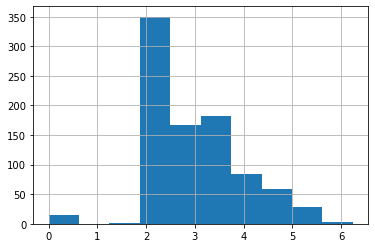

In [3]:
X.Norm_Fare.hist()

In [49]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

nub_col = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
cag_col = ['Embarked', 'Title']


X = pd.get_dummies(X, columns=cag_col)
test = pd.get_dummies(test, columns=cag_col)
X_scaled = X.copy()
X_scaled[['Age','SibSp','Parch','Norm_Fare']] = scale.fit_transform(X_scaled[['Age','SibSp','Parch','Norm_Fare']])

test_scaled = test.copy()
test_scaled[['Age','SibSp','Parch','Norm_Fare']] = scale.fit_transform(test_scaled[['Age','SibSp','Parch','Norm_Fare']])


In [50]:
print(X_scaled.shape, X.shape)

(891, 15) (891, 15)


In [5]:
X.describe()

,Pclass,Sex,Age,SibSp,Parch,Norm_Fare,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_blah
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.647587,29.361582,0.523008,0.381594,2.962246,0.190797,0.086420,0.722783,0.007856,0.044893,0.204265,0.580247,0.140292,0.022447
std,0.836071,0.477990,13.019697,1.102743,0.806057,0.969048,0.393150,0.281141,0.447876,0.088337,0.207186,0.403390,0.493796,0.347485,0.148214
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,2.187218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,28.000000,0.000000,0.000000,2.737881,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,3.465736,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,6.240917,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


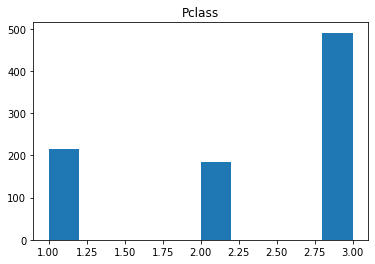

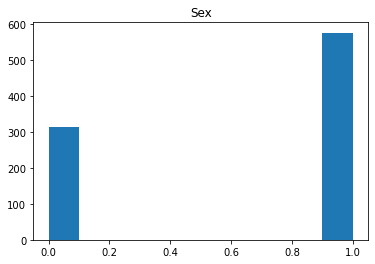

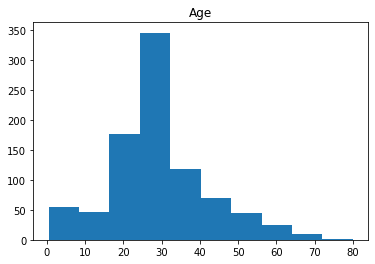

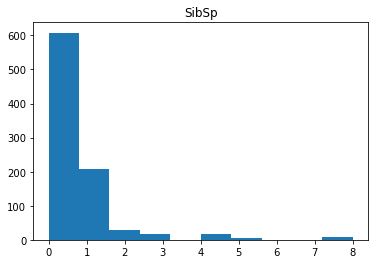

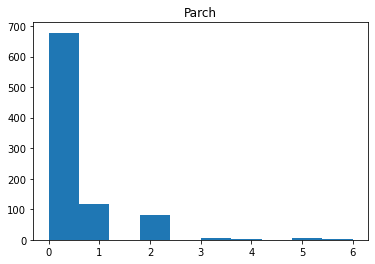

In [6]:
for name in nub_col:
    plt.hist(X[name])
    plt.title(name)
    plt.show()

In [7]:
pd.pivot_table(data, index='Survived', values = nub_col)

,Age,Parch,Pclass,SibSp
Survived,,,,
0,30.626179,0.329690,2.531876,0.553734
1,28.343690,0.464912,1.950292,0.473684


Text(0.5, 1.0, 'Correlation bewteen Variables')

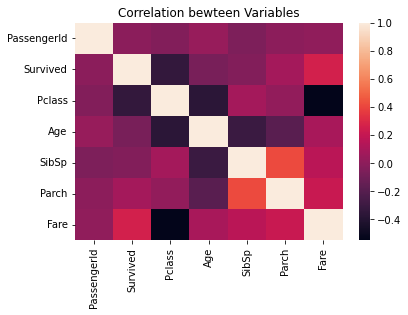

In [8]:
sns.heatmap(data.corr()).set_title("Correlation bewteen Variables")

In [9]:
for name in ['Pclass', 'Sex', 'Embarked']:
    print(pd.pivot_table(data, index= 'Survived', columns= name, values='Ticket', aggfunc='count'))
    print()

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217



In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
#This was a pipeline but decided to do by hand instead
# numerical_transformer = SimpleImputer(strategy='most_frequent')

# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessor = ColumnTransformer(
#     transformers=[
#        ('cat', categorical_transformer, cag_col), 
#        ('num', numerical_transformer, nub_col),
#     ])
# my_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', model)
#     ])
# my_pipeline.fit(X_train, y_train)
# preds = my_pipeline.predict(test)

In [51]:
from sklearn.metrics import accuracy_score
def get_score(model):
    cv = cross_val_score(model, X,y, cv=5)
    cv_scaled = cross_val_score(model, X_scaled,y, cv=5)
    print("Regular X",cv.mean())
    return print("Scaled X",cv_scaled.mean())

In [52]:
rf = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=10, oob_score=True, bootstrap=True)
get_score(rf)

Regular X 0.8204381394764925
Scaled X 0.8215554579122466


In [53]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200, eval_metric='rmse', use_label_encoder=False, learning_rate=0.01, random_state=0)
get_score(xgb)
xgb.fit(X,y)
new_preds = xgb.predict(test)

Regular X 0.8383780051471973
Scaled X 0.8383780051471973


In [54]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=2000)
get_score(lr)

Regular X 0.8204318624066286
Scaled X 0.8215491808423827


In [55]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
get_score(gnb)

Regular X 0.7912623187496077
Scaled X 0.7912623187496077


In [56]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(random_state=0)
get_score(dt)

Regular X 0.7733036218693113
Scaled X 0.7744146632352018


In [57]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
get_score(knn)

Regular X 0.7935220639005712
Scaled X 0.8204318624066286


In [58]:
from sklearn.svm import SVC
svc = SVC(probability=True)
get_score(svc)

Regular X 0.7183353210721235
Scaled X 0.8305065595380077


In [59]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 
get_score(voting_clf)

Regular X 0.822666499278137
Scaled X 0.8249011361496453


In [60]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [61]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [62]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_scaled, y)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.8226727763480008
Best Parameters: {'C': 4.281332398719396, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [63]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_scaled,y)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8305504990270542
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


In [70]:
# svc = SVC(probability = True)
# param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
#                                   'C': [.1, 1, 10, 100, 1000]},
#                                  {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
#                                  {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
# clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
# best_clf_svc = clf_svc.fit(X,y)
# clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits


In [64]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_scaled,y)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Random Forest
Best Score: 0.8439897056054233
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


<AxesSubplot:>

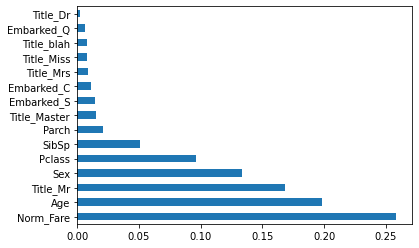

In [66]:
best_rf = best_clf_rf.best_estimator_.fit(X_scaled, y)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [65]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_scaled,y)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\j4cks\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
Best Score: 0.8440085368150149
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 550, 'reg_alpha': 1, 'reg_lambda': 5, 'sampling_method': 'uniform', 'subsample': 0.65}


XGB best was 0.84402

In [34]:
preds1 = best_clf_lr.predict(test)

In [53]:
#Fitting for the Submission
rf.fit(X_train, y_train)
preds = rf.predict(test)

In [54]:
#Fitting for the Submission
xgb.fit(X, y)
preds = xgb.predict(test)

In [36]:
output = pd.DataFrame({'PassengerId': valid.PassengerId,'Survived': preds1})

output.to_csv('submission.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
output2 = pd.DataFrame({'PassengerId': valid.PassengerId,'Survived': preds})

In [ ]:
output2.Survived.value_counts()